In [3]:
import os
import sys

# code for enabling this notebook to work within cursor
coralme_dir = '../'#'/home/chris/zuniga/coralme/'
sys.path.insert(0, coralme_dir)
sys.path.insert(0, '../')

import importlib
import coralme
import coralme.solver.solver
import coralme.builder.main
import coralme.core.model
import os
import pandas as pd
import json
import cobra
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text
from coralme.util.helpers import get_nlp, optimize
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from coralme.builder.main import MEBuilder

In [4]:
# go through each model to generate solutions
base_dir = os.path.join(coralme_dir, 'species_files', 'Pseudomonas_files')
info_df = pd.read_excel(os.path.join(base_dir,'Strain_models_genome-information_predictedM9.xlsx'), index_col = 0)
for index, row in info_df.iterrows():
    if index == 'Reference': continue

    # check if model exists and solution not already saved off
    out_dir = base_dir+'/individual_species/'+index+'/'
    model_name = row['organism'].replace(' ', '_')+'_'+row['strain'].replace(' ','_')
    out_model = out_dir+'/outputs/MEModel-step3-'+model_name+'-TS.pkl'
    out_sol = out_dir+'/outputs/saved_solution.pkl'
    if not os.path.exists(out_model):
        print(str(index)+' skipped, model doesn\'t yet exist')
        continue
    if os.path.exists(out_sol):
        print(str(index)+' skipped, solution already exists')
        continue

    # load model, run model
    ME_model = coralme.io.pickle.load_pickle_me_model(out_model)
    ME_model.optimize(tolerance = 1e-3)
    try:
        ME_sol = ME_model.solution
    except:
        ME_sol = None

    # save the solution off
    pickle_out = open(out_sol, 'wb')
    pickle.dump(ME_sol, pickle_out)
    pickle_out.close()

Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	1.4050280687025918	Not feasible
        2	0.7025140343512959	Not feasible
        3	0.3512570171756479	Not feasible
        4	0.1756285085878240	Not feasible
        5	0.0878142542939120	Not feasible
        6	0.0439071271469560	Optimal
        7	0.0658606907204340	Not feasible
        8	0.0548839089336950	Not feasible
        9	0.0493955180403255	Not feasible
       10	0.0466513225936407	Not feasible
       11	0.0452792248702984	Not feasible
       12	0.0445931760086272	Optimal
CP041013 skipped, model doesn't yet exist
CP039749 skipped, model doesn't yet exist
CP065865 skipped, model doesn't yet exist
CP065867 skipped, model doesn't yet exist
LR590473 skipped, model doesn't yet exist
CP008749.1 skipped, model doesn't yet exist
AE004091.2 skipped, model doesn't yet exist
CP068238 skipped, model doesn't yet exist
CP014784 skipped, model doesn't yet exist
CP061848 skipped, model doesn't yet ex

In [4]:
# go through each model to create a dataframe of reduced and shadow prices
base_dir = os.path.join(coralme_dir, 'species_files', 'Pseudomonas_files')
info_df = pd.read_excel(os.path.join(base_dir,'Strain_models_genome-information_predictedM9.xlsx'), index_col = 0)
shadows_dfs = []
reduced_dfs = []
flux_dfs = []
indices = []
obj_values = []
for index, row in info_df.iterrows():
    if index == 'Reference': continue

    # check if model exists and solution not already saved off
    out_dir = base_dir+'/individual_species/'+index+'/'
    out_sol = out_dir+'/outputs/saved_solution.pkl'
    if not os.path.exists(out_sol):
        print(str(index)+' skipped, solution doesn\'t yet exist')
        continue

    # load solution
    pickle_in = open(out_sol, 'rb')
    ME_sol = pickle.load(pickle_in)
    pickle_in.close()
    if ME_sol:
        ind = (index+'__'+row['organism']+'__'+row['strain']).replace(' ', '_')
        indices.append(ind)
        shadows_dfs.append(pd.Series(ME_sol.shadow_prices))
        reduced_dfs.append(pd.Series(ME_sol.reduced_costs))
        flux_dfs.append(pd.Series(ME_sol.fluxes))
        obj_values.append(ME_sol.objective_value)

# remove dummy reactions
drop_words = ['dummy', 'CPLX']
shadow_df = pd.DataFrame(shadows_dfs, index = indices)
shared_cols = shadow_df.columns[shadow_df.count() == len(shadow_df)]
keep = []
for col in shared_cols:
    if not any(word in col for word in drop_words):
        keep.append(col)
shadow_df = shadow_df[keep]
shadow_df['obj_value'] = obj_values
shadow_df.iloc[:, :-1] = shadow_df.iloc[:, :-1].div(shadow_df['obj_value'], axis=0)
reduced_df = pd.DataFrame(reduced_dfs, index = indices)
shared_cols = reduced_df.columns[reduced_df.count() == len(reduced_df)]

# flux df
flux_df = pd.DataFrame(flux_dfs, index = indices)
shared_cols = flux_df.columns[flux_df.count() == len(flux_df)]
keep = []
for col in shared_cols:
    if not any(word in col for word in drop_words):
        keep.append(col)
flux_df = flux_df[keep]
flux_df['obj_value'] = obj_values
flux_df.iloc[:, :-1] = flux_df.iloc[:, :-1].div(flux_df['obj_value'], axis=0)

CP065866 skipped, solution doesn't yet exist
CP041013 skipped, solution doesn't yet exist
CP039749 skipped, solution doesn't yet exist
CP065865 skipped, solution doesn't yet exist
CP065867 skipped, solution doesn't yet exist
LR590473 skipped, solution doesn't yet exist
CP008749.1 skipped, solution doesn't yet exist
AE004091.2 skipped, solution doesn't yet exist
CP068238 skipped, solution doesn't yet exist
CP014784 skipped, solution doesn't yet exist
CP061848 skipped, solution doesn't yet exist
CP061335 skipped, solution doesn't yet exist
CP053697 skipped, solution doesn't yet exist
CP070982 skipped, solution doesn't yet exist
LS483372 skipped, solution doesn't yet exist
CP012830 skipped, solution doesn't yet exist
CP012831 skipped, solution doesn't yet exist
CP008896 skipped, solution doesn't yet exist
CP015225 skipped, solution doesn't yet exist
CP060288 skipped, solution doesn't yet exist
CP022562 skipped, solution doesn't yet exist
CP050291 skipped, solution doesn't yet exist
CP0431

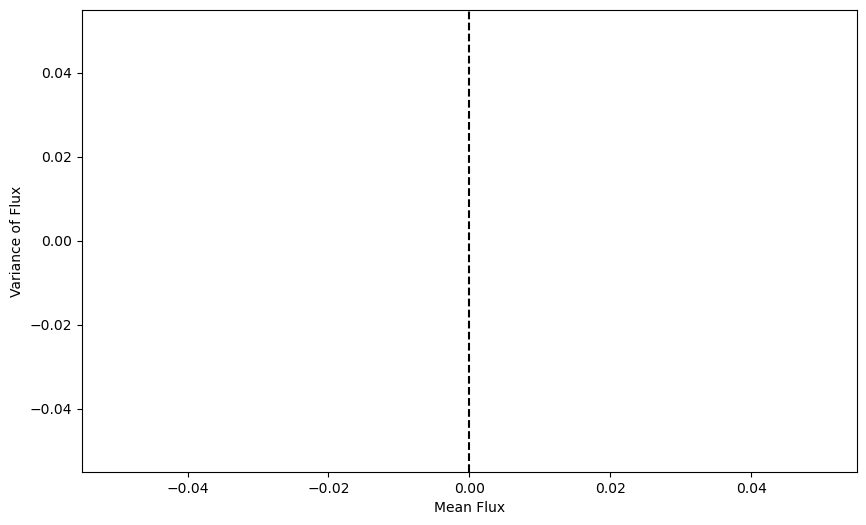

In [7]:
# Create the scatter plot
means = flux_df.mean()
vars = flux_df.var()
disp_df = pd.DataFrame({'mean' : means, 'var' : vars})
disp_df['disp'] = disp_df['var']/disp_df['mean']
disp_df.sort_values('disp', ascending = False)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(disp_df['mean'], disp_df['var'])

# Find outliers (for example, points with high mean or variance)
# You can adjust these thresholds based on your data
mean_threshold = np.percentile(disp_df['mean'], 95)  # top 5% of mean values
var_threshold = np.percentile(disp_df['var'], 95)    # top 5% of variance values

# Create list of texts for outlier points
texts = []
for idx, row in disp_df.iterrows():
    if row['mean'] > mean_threshold or row['var'] > var_threshold:
        texts.append(plt.text(row['mean'], row['var'], idx))

# Adjust text positions to prevent overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

plt.xlabel('Mean Flux')
plt.ylabel('Variance of Flux')
plt.axvline(x = 0, color = 'black', linestyle = '--')
plt.show()

# look at top shadow prices and reduced costs

In [6]:
len(reduced_df)

26

# logistic regression - results in really poor accuracy

In [50]:
# Get the organism labels from info_df
y = info_df.loc[flux_df.index, 'organism']

# Prepare the features (reduced costs)
X = flux_df.drop('obj_value', axis=1)  # Remove the objective value column

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# Train the logistic regression model
model = LogisticRegression(multi_class = 'multinomial', solver = 'saga', penalty = 'l1', max_iter = 2000)
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Print classification report
print("Classification Report:")
print(classification_report(y, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(model.coef_).mean(axis=0)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Most Important Features')
plt.show()

/home/chris/miniforge3/envs/coralme/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/chris/miniforge3/envs/coralme/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/chris/miniforge3/envs/coralme/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chris/miniforge3/envs/coralme/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-d

Classification Report:
                             precision    recall  f1-score   support

     Pseudomonas aeruginosa       0.00      0.00      0.00         9
    Pseudomonas alcaligenes       0.00      0.00      0.00         1
       Pseudomonas asiatica       1.00      0.50      0.67         2
          Pseudomonas campi       0.00      0.00      0.00         1
    Pseudomonas entomophila       0.00      0.00      0.00         1
    Pseudomonas fluorescens       0.67      0.50      0.57         4
      Pseudomonas mendocina       0.00      0.00      0.00         1
      Pseudomonas monteilii       0.00      0.00      0.00         1
Pseudomonas plecoglossicida       0.00      0.00      0.00         1
      Pseudomonas protegens       0.00      0.00      0.00         1
         Pseudomonas putida       0.44      0.80      0.57         5
            Pseudomonas sp.       0.44      1.00      0.62        12
       Pseudomonas stutzeri       0.00      0.00      0.00         1
  Pseudomo

ValueError: Found input variables with inconsistent numbers of samples: [5, 41]